In [1]:
from spotLight import spotXAI

from spotPython.data.diabetes import Diabetes
from spotPython.light.regression.netlightregression import NetLightRegression
from spotPython.utils.classes import get_removed_attributes_and_base_net

from torch.nn import ReLU
import torch

import numpy as np

import matplotlib.pyplot as plt

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
seed = 121314
torch.manual_seed(seed)
np.random.seed(seed)

### Exemplary dictionary with the HP config for a network

In [4]:
example_config = {
    "l1": 64,
    "epochs": 1024,
    "batch_size": 32,
    "act_fn": ReLU(),
    "optimizer": "AdamW",
    "dropout_prob": 0.04938229888019609,
    "lr_mult": 2.3689895017756495,
    "patience": 64,
    "initialization": "Default",
}

### Building the spot Lightning Architecture

In [5]:
model = NetLightRegression(**example_config, _L_in=10, _L_out=1, _torchmetric="mean_squared_error")

#### Usage of `get_removed_attributes_and_base_net` to transform the Lightning module to a plain pyTorch module

Hint: The remaining training attributes will be later used for the analyzer. This dictionary includes parameters that are relevant for the training of the model like batch size, epochs, optimizer or loss function

In [6]:
removed_attributes, torch_net = get_removed_attributes_and_base_net(net=model)
removed_attributes

{'_hparams_initial': "act_fn":         ReLU()
 "batch_size":     32
 "dropout_prob":   0.04938229888019609
 "epochs":         1024
 "initialization": Default
 "l1":             64
 "lr_mult":        2.3689895017756495
 "optimizer":      AdamW
 "patience":       64,
 '_compiler_ctx': None,
 '_dtype': torch.float32,
 '_torchmetric': 'mean_squared_error',
 '_device': device(type='cpu'),
 '_param_requires_grad_state': {},
 'metric': <function torchmetrics.functional.regression.mse.mean_squared_error(preds: torch.Tensor, target: torch.Tensor, squared: bool = True, num_outputs: int = 1) -> torch.Tensor>,
 '_automatic_optimization': True,
 '_strict_loading': None,
 '_L_in': 10,
 'allow_zero_length_dataloader_with_multiple_devices': False,
 '_hparams_name': 'kwargs',
 '_metric_attributes': None,
 '_hparams': "act_fn":         ReLU()
 "batch_size":     32
 "dropout_prob":   0.04938229888019609
 "epochs":         1024
 "initialization": Default
 "l1":             64
 "lr_mult":        2.36898950

In [7]:
torch_net

NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.04938229888019609, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.04938229888019609, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.04938229888019609, inplace=False)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.04938229888019609, inplace=False)
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)

### Select a data set

In [8]:
dataset = Diabetes(target_type=torch.float)

### Define the analyzer by handing over the generated model, the data set, a train split ratio and the dictionary consisting of the "removed attributes"


In [9]:
analyzer = spotXAI(model=torch_net, data=dataset, train_split=0.6, training_attributes=removed_attributes, seed=seed)

#### Train the weights of the model

In [10]:
analyzer.train_model()

epochs 1/1024
train loss:  866.71484375
epochs 2/1024
train loss:  881.30859375
epochs 3/1024
train loss:  869.5390625
epochs 4/1024
train loss:  871.146484375
epochs 5/1024
train loss:  862.777587890625
epochs 6/1024
train loss:  817.7645874023438
epochs 7/1024
train loss:  730.3733520507812
epochs 8/1024
train loss:  568.2132568359375
epochs 9/1024
train loss:  320.0679016113281
epochs 10/1024
train loss:  162.93284606933594
epochs 11/1024
train loss:  165.28424072265625
epochs 12/1024
train loss:  146.8558349609375
epochs 13/1024
train loss:  141.18215942382812
epochs 14/1024
train loss:  137.08836364746094
epochs 15/1024
train loss:  143.9729766845703
epochs 16/1024
train loss:  127.62203216552734
epochs 17/1024
train loss:  127.59711456298828
epochs 18/1024
train loss:  123.86201477050781
epochs 19/1024
train loss:  113.08658599853516
epochs 20/1024
train loss:  118.4745101928711
epochs 21/1024
train loss:  117.04740142822266
epochs 22/1024
train loss:  117.3521499633789
epochs 23

#### Perform the attribution analysis

In [11]:
# baseline = torch.Tensor([[0.1,0.1,0.1,0.2,0.1,0.1,0.1,0.2,0.1, 0.2]])
df = analyzer.get_n_most_sig_features(n_rel=10, attr_method="IntegratedGradients", baseline=None)

In [12]:
df

,Feature Index,IntegratedGradientsAttribution
0,9,1806.188357
1,2,1028.623668
2,10,957.370277
3,1,819.819406
4,4,805.643744
5,3,626.849691
6,5,247.164688
7,7,151.326156
8,8,103.297722
9,6,-3.788243


#### Plot the results

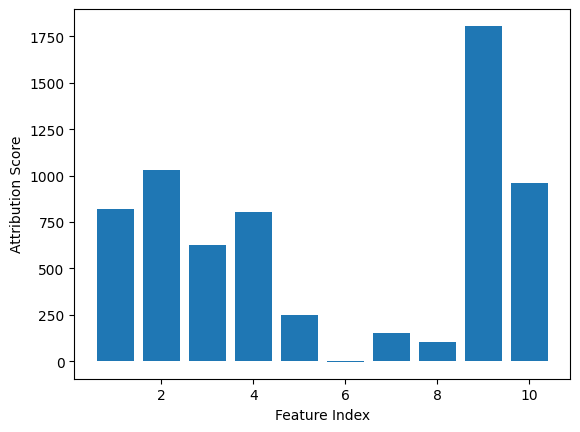

In [13]:
plt.bar(df["Feature Index"], df["IntegratedGradientsAttribution"])
plt.xlabel("Feature Index")
plt.ylabel("Attribution Score")
plt.show()